In [26]:
plt.style.use('dark_background')
import itertools
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import pandas as pd
import time



For a trinomial tree, the formula for the stock price is given by
\begin{align*}
S^n_k=S_0 u^{n
}d^k,\qquad n=0,1,...,N\quad k=0,1,...,n
\end{align*}
is the $k^{th}$ possible stock price level at time $n$, and $V^n_k$ is the time-$n$ option value when the stock price is $S^n_k$. 





\begin{align*}{Euro. option: }V^{n}_k&=e^{-r\triangle t}[quV^{n+1}_{k} + qmV^{n+1}_{k+1}+qdV^{n+1}_{k+2}]\quad\text{for each }k=0,1,...,n \\
\end{align*}
\begin{align*}{Amer. option: }V^{n}_k&=max(g(S^n_k),e^{-r\triangle t}[quV^{n+1}_{k} + qmV^{n+1}_{k+1}+qdV^{n+1}_{k+2}])\quad\text{for each }k=0,1,...,n \\
\end{align*}

In case one wants to visualize the tree

*Choosing the tree parameters*

There are a number of ways we can choose the tree parameters. Here we use the Kamrad_Ritchken model:
	\begin{align*}
	\quad u=e^{\lambda\sigma\sqrt{\triangle t}},\quad m=1,\quad d=e^{-\lambda\sigma \sqrt{\triangle t}}\\
    \quad qu=\frac{1}{2\lambda^2}+\frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\sigma\lambda},\quad qm=1-\frac{1}{\lambda^2},\quad qd=\frac{1}{2\lambda^2}-\frac{(r-\frac{\sigma^2}{2})\sqrt{\triangle t}}{2\sigma\lambda}
    \end{align*}

In [2]:
def GetKamrad_RitchkenPara(lambda_param,r, T, N, sigma):
    dt = T/N
    u = np.exp(sigma*lambda_param * np.sqrt(dt))
    m = 1
    d= 1/u
    R = np.exp(r * dt)
    qu = ((1) / (2*lambda_param**2)) + (r-0.5*sigma**2)*np.sqrt(dt)/(2*sigma*lambda_param)
    qm = 1 - (1/(lambda_param**2))
    qd = ((1) / (2*lambda_param**2)) - (r-0.5*sigma**2)*np.sqrt(dt)/(2*sigma*lambda_param)
    return u, d, qu, qm, qd, R


In [3]:
def Populate_Tree_Tri(S0, T, r, N,sigma):
        
    # Create empty arrays to store the stock price at each node
    S = np.zeros((2*N+1, N+1))
    S[0,0]=S0
    u, d, qu, qm, qd, R = GetKamrad_RitchkenPara(lambda_param,r, T, N, sigma)
    
    # Set up S[k,n] = s0 * u^(n) * d^k
    for t in range(N+1):
        S[0:2*t+1, t] = S0 * u**np.arange(t, -t-1, -1).astype(float)
        
    return S     # get the function to return the whole tree of stock prices

In [4]:
#An example

S0, r, T, sigma, K = 100, 0.01, 1, 0.2, 100     # Option and market parameters
N = 2                                          # Number of periods
lambda_param = 1
S=Populate_Tree_Tri(S0, T, r, N,sigma)
S

array([[100.        , 115.19099102, 132.68964411],
       [  0.        , 100.        , 115.19099102],
       [  0.        ,  86.81234454, 100.        ],
       [  0.        ,   0.        ,  86.81234454],
       [  0.        ,   0.        ,  75.36383164]])

## floating strike lookback put

In [5]:
#Aux var: Auxiliary_variable_lookback_put_floating_strike
def Lookback_FSP_Aux(S0,u,N):
    M_Grid = np.zeros((N+1, N+1))
    
    for t in range(N+1):
        M_Grid[0:t+1, t] = S0 * u**np.arange(t, -1, -1)
            
    #phi = lambda k,j: np.maximum(k-n-1,j) #Shooting function
    phi = lambda k,j: np.minimum(k,j+1) #Shooting function
    
    return M_Grid, phi


In [6]:
def Trinomial_CRR_Shooting_grid(S0, T, r, N,aux_function,sigma,american=False):
        
    # Create empty arrays to store the stock price at each node
    V = np.zeros((N+1,2*N+1, N+1))
    u, d, qu, qm, qd, R = GetKamrad_RitchkenPara(lambda_param,r, T, N, sigma)

# Set up S[k,n] = s0 * u^(n)* d^k
    S=Populate_Tree_Tri(S0, T, r, N,sigma)
    M_Grid, phi = aux_function(S0,u,N)
    

            
# Compute the option price at terminal time
    for k in range(0,(2*N)+1):
        for j in range(0,N+1):
            V[j,k,N] = M_Grid[j,N] - S[k,N]
            #print(M_Grid[j,N],S[k,N])
    
    for n in reversed(range(N)):    
        for k in (range(0,2*n+1)):
            for j in range(0,n+1):
                if american:
                    V[j,k,n] = max(M_Grid[j,n] - S[k,n],(qu*V[phi(k,j),k,n+1]+qm*V[phi(k+1,j),k+1,n+1]+qd*V[phi(k+2,j),k+2,n+1])/R)
                else:
                    V[j,k,n] = (qu*V[phi(k,j),k,n+1]+qm*V[phi(k+1,j),k+1,n+1]+qd*V[phi(k+2,j),k+2,n+1])/R
    return V[0,0,0]

In [7]:
#European Case
N=2
Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=False)

10.291817023033659

In [8]:
#European Case
N=50
Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=False)

14.861644163246314

In [9]:
#American Case
Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=True)

15.00844782735167

In [10]:
## Computing prices for different N for both EU and US options

No handles with labels found to put in legend.


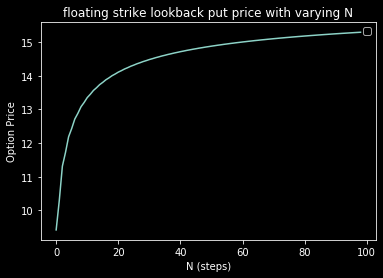

In [31]:
List_EU_LFSP_Prices=[Trinomial_CRR_Shooting_grid(S0, T, r, i,Lookback_FSP_Aux, sigma,american=False) for i in range(1,100)]
plt.legend(loc="best")
plt.title("floating strike lookback put price with varying N")
plt.xlabel("N (steps)")
plt.ylabel("Option Price")
plt.plot(List_EU_LFSP_Prices)

In [17]:
#An example

S0, r, T, sigma, K = 100, 0.01, 1, 0.2, 100     # Option and market parameters
N = 2                                          # Number of periods
lambda_param = 1

### European Case

In [18]:
N=10
t0=time.time()
eu_price_lfsp_10=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=False)
tend=time.time()
eu_time_lfsp_10=tend-t0

N=20
t0=time.time()
eu_price_lfsp_20=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=False)
tend=time.time()
eu_time_lfsp_20=tend-t0

N=50
t0=time.time()
eu_price_lfsp_50=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=False)
tend=time.time()
eu_time_lfsp_50=tend-t0

N=100
t0=time.time()
eu_price_lfsp_100=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=False)
tend=time.time()
eu_time_lfsp_100=tend-t0

N=200
t0=time.time()
eu_price_lfsp_200=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=False)
tend=time.time()
eu_time_lfsp_200=tend-t0

N=500
t0=time.time()
eu_price_lfsp_500=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=False)
tend=time.time()
eu_time_lfsp_500=tend-t0


eu_list_prices = [eu_price_lfsp_10,eu_price_lfsp_50, eu_price_lfsp_50, 
                  eu_price_lfsp_100, eu_price_lfsp_200, eu_price_lfsp_500]
eu_list_time = [eu_time_lfsp_10,eu_time_lfsp_20,eu_time_lfsp_50,
                eu_time_lfsp_100, eu_time_lfsp_200, eu_time_lfsp_500]

In [19]:
eu_list_prices
eu_list_time

[0.003953456878662109,
 0.022971630096435547,
 0.317141056060791,
 2.5494203567504883,
 21.463724374771118,
 338.3564360141754]

## American Case

In [20]:
N=10
t0=time.time()
am_price_lfsp_10=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=True)
tend=time.time()
am_time_lfsp_10=tend-t0

N=20
t0=time.time()
am_price_lfsp_20=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=True)
tend=time.time()
am_time_lfsp_20=tend-t0

N=50
t0=time.time()
am_price_lfsp_50=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=True)
tend=time.time()
am_time_lfsp_50=tend-t0

N=100
t0=time.time()
am_price_lfsp_100=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=True)
tend=time.time()
am_time_lfsp_100=tend-t0

N=200
t0=time.time()
am_price_lfsp_200=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=True)
tend=time.time()
am_time_lfsp_200=tend-t0

N=500
t0=time.time()
am_price_lfsp_500=Trinomial_CRR_Shooting_grid(S0, T, r, N,Lookback_FSP_Aux, sigma,american=True)
tend=time.time()
am_time_lfsp_500=tend-t0
am_time_lfsp_500

am_list_prices = [am_price_lfsp_10,am_price_lfsp_50, 
                  am_price_lfsp_50, am_price_lfsp_100, am_price_lfsp_200, am_price_lfsp_500]
am_list_time = [am_time_lfsp_10,am_time_lfsp_20,am_time_lfsp_50,
                am_time_lfsp_100, am_time_lfsp_200, am_time_lfsp_500]

In [21]:
am_list_prices

[13.393334495658443,
 15.00844782735167,
 15.00844782735167,
 15.434824126370037,
 15.747517108717334,
 16.03297682299477]

### EU-Am Prices vs Time

In [38]:
list_N=[10,20,50,100,200,500]

Table_EU=pd.DataFrame({"N":list_N,"EU Prices":eu_list_prices,
                       "Computational time (seconds)":eu_list_time})
Table_EU

,N,EU Prices,Computational time (seconds)
0,10,13.204753,0.003953
1,20,14.861644,0.022972
2,50,14.861644,0.317141
3,100,15.294589,2.549420
4,200,15.610695,21.463724
5,500,15.898234,338.356436


In [40]:
Table_AM=pd.DataFrame({"N":list_N,"AM Prices":am_list_prices,
                       "Computational time (seconds)":am_list_time})
Table_AM

,N,AM Prices,Computational time (seconds)
0,10,13.393334,0.004087
1,20,15.008448,0.025280
2,50,15.008448,0.368047
3,100,15.434824,3.146343
4,200,15.747517,24.155889
5,500,16.032977,402.013110
